In [33]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
class Value:
    def __init__(self, data, __children={}, _op="", label=""):
        self.data = data
        self.grad = 0
        self._prev = set(__children)
        self._op = _op
        self._backward = lambda: None
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def __rmul__(self, other):
        return self * other
    def __radd__(self, other): # other + self
        return self + other
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out = Value(self.data * other.data, (self, other), "*")
        out._backward = _backward
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/floa powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1
    def tanh(self):
        def _backward():
            self.grad += (1 - t**2) * out.grad
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        out._backward = _backward
        return out
    def exp(self):
        def _backward():
            self.grad += out.data * out.grad
        n = self.data
        out = Value(math.exp(n), (self, ), 'exp')
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if(v not in visited):
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [132]:
from graphviz import Digraph

def trace(root):
    # build a set of all the nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if(v not in nodes):
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(v=root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if(n._op):
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [133]:
import torch
import random

x1 = torch.Tensor([2.0]).double(); x1.requires_grad=True
w1 = torch.Tensor([0.0]).double(); w1.requires_grad=True
x2 = torch.Tensor([-3.0]).double(); x2.requires_grad=True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad=True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()



0.9991497879990848


In [134]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1)) # bias controlling overall trigger happiness
    def __call__(self, x):
        wx_zip = zip(self.w, x) #takes 2 iternates and creates a new interator which iterates over tuples of corresponding entries
        act = sum((wi*xi for wi, xi in zip(self.w, x)),self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
                       
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
                       
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.059301952466534066)

In [135]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.059301952466534066),
 Value(data=0.8259360414130396),
 Value(data=-0.5094412076230891),
 Value(data=0.5706742292406556)]

In [136]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

In [137]:
loss

Value(data=4.881131600046932)

In [138]:
loss.backward()

In [139]:
n.layers[0].neurons[0].w[0].grad

0.4415926068261318

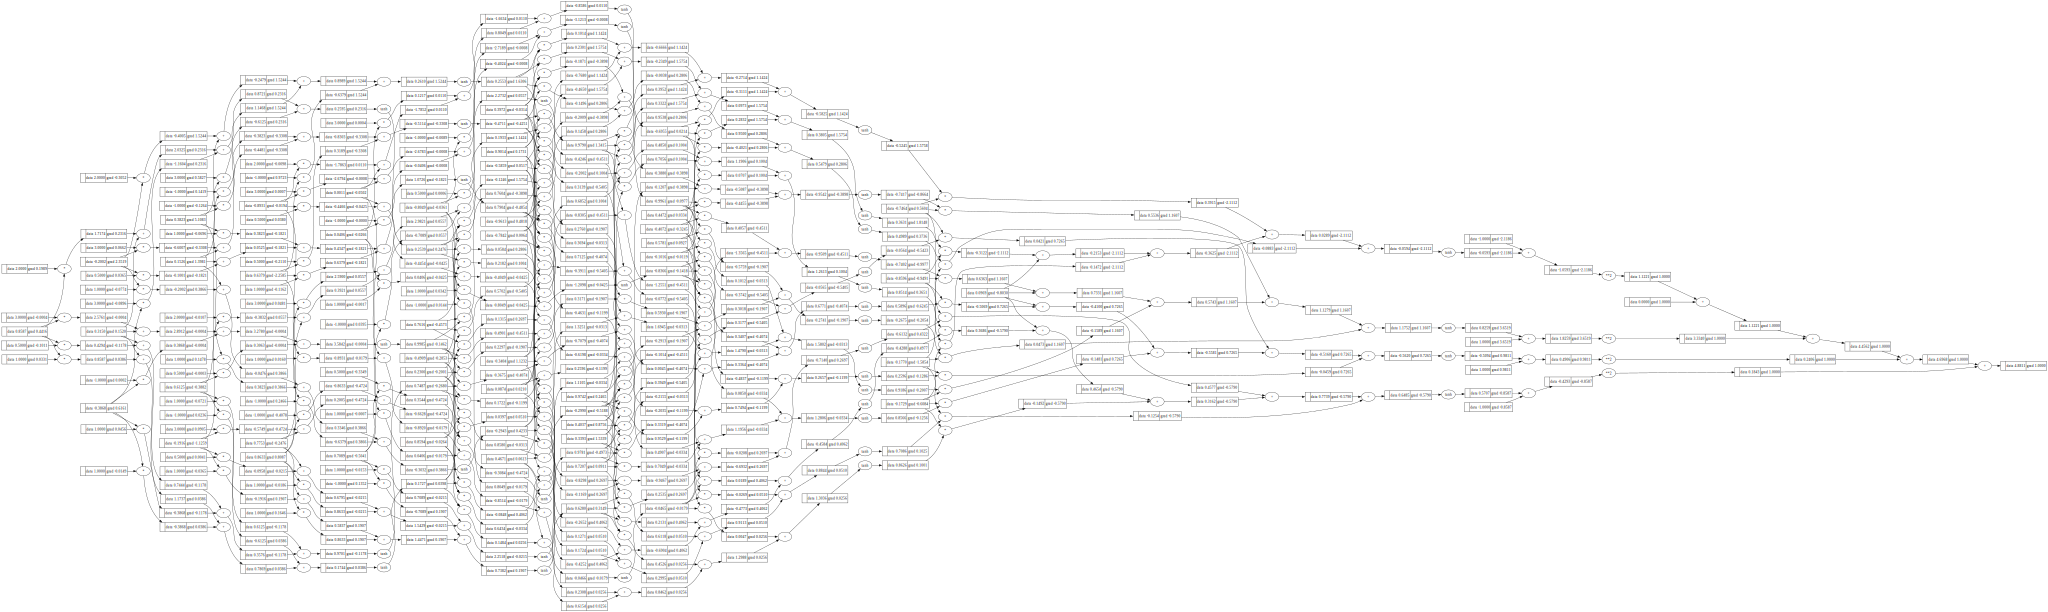

In [141]:
draw_dot(loss)